# Data Visualization

In [1]:
from src.data import transform_data
from src.data.augmentation import Augment

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, default_collate
from datasets import load_dataset, Array4D

In [2]:
num_proc = 2
dataset = load_dataset("oxkitsune/open-kbp", num_proc=num_proc)
dataset = (
    dataset.with_format("numpy")
    .map(
        transform_data,
        input_columns=["ct", "structure_masks"],
        # we remove these columns as they are combined into the 'features' column or irrelevant
        remove_columns=["ct", "structure_masks", "possible_dose_mask"],
        writer_batch_size=25,
        num_proc=num_proc,
    )
    # cast the features column to a 4D array, to make converting to torch 100x faster
    .cast_column("features", Array4D((128, 128, 128, 3), dtype="float32"))
)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dataset = dataset.with_format("torch", columns=["features", "dose"], device=device)

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
augment = Augment(1)
def transform(samples):
    samples = default_collate(samples)
    samples["features"] = augment(samples["features"])
    print(samples["dose"].dim())
    samples["dose"] = augment(samples["dose"])

    return samples

In [4]:
train_dataloader_orig = DataLoader(dataset["train"], batch_size=1)
train_dataloader_aug = DataLoader(dataset["train"], batch_size=1, collate_fn=transform)
batch = next(iter(train_dataloader_orig))
batch_aug = next(iter(train_dataloader_aug))

4


# CT Scan

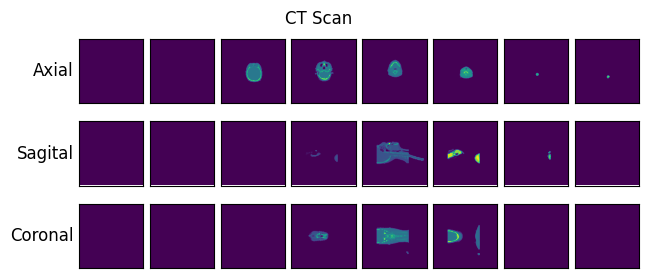

In [5]:
scan = np.squeeze(batch["features"])[:,:,:,0].cpu()

def plot_views(data, title):
    columns = 8
    rows = 3
    spacing = 128 // columns

    fig, axis = plt.subplots(ncols=columns, nrows=rows, figsize=(columns, rows))
    fig.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
    
    for j in range(columns):
        ax = axis[0, j]
        ax.imshow(data[:, :, j*spacing])
        ax.set_xticks([])
        ax.set_yticks([])
    
    for j in range(columns):
        ax = axis[1, j]
        ax.imshow(data[:, j*spacing, :])
        ax.set_xticks([])
        ax.set_yticks([])
    
    for j in range(columns):
        ax = axis[2, j]
        ax.imshow(data[j*spacing, :, :])
        ax.set_xticks([])
        ax.set_yticks([])
    
    labels = ["Axial", "Sagital", "Coronal"]
    
    for i, label in enumerate(labels):
        ax = axis[i, 0]
        ax.set_ylabel(label, rotation=0, size='large', ha='right', va='center')
    
    plt.suptitle(title)
    plt.savefig(f"./figs/{title}.png")

plot_views(scan, "CT Scan")

# OARs

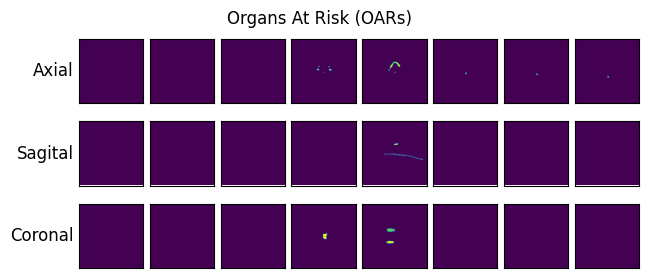

In [6]:
scan = np.squeeze(batch["features"])[:,:,:,1].cpu()
plot_views(scan, "Organs At Risk (OARs)")

# PTVs

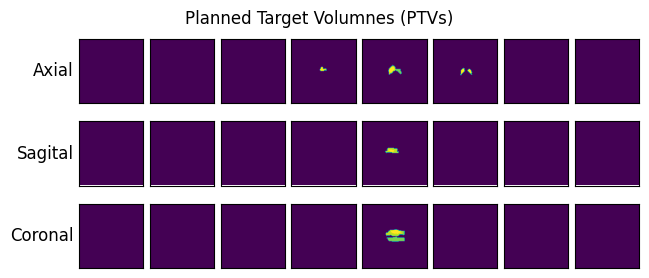

In [7]:
scan = np.squeeze(batch["features"])[:,:,:,2].cpu()
plot_views(scan, "Planned Target Volumnes (PTVs)")

# Dose

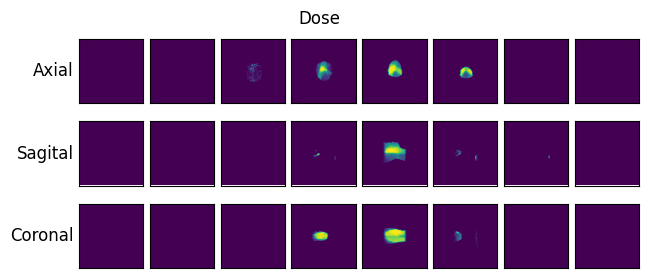

In [8]:
scan = np.squeeze(batch["dose"])[:,:,:].cpu()
plot_views(scan, "Dose")

# Augmentations

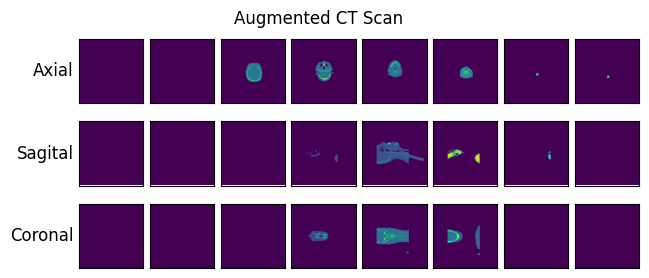

In [9]:
scan = np.squeeze(batch["features"])[:,:,:,0].cpu()
plot_views(scan, "Augmented CT Scan")

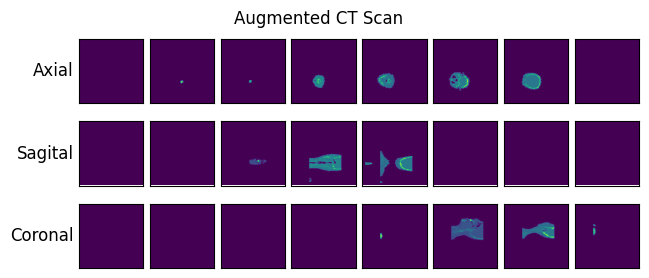

In [10]:
scan = np.squeeze(batch_aug["features"])[:,:,:,0].cpu()
plot_views(scan, "Augmented CT Scan")

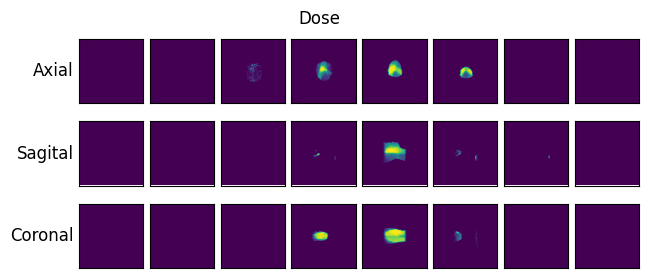

In [12]:
scan = np.squeeze(batch["dose"])[:,:,:].cpu()
plot_views(scan, "Dose")

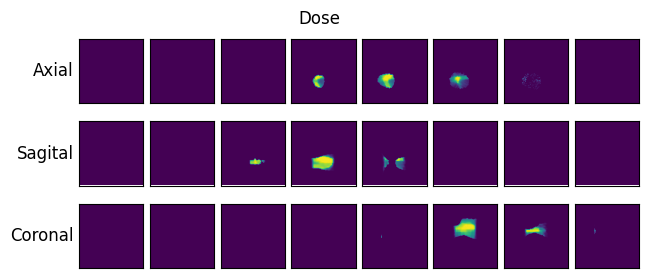

In [13]:
scan = np.squeeze(batch_aug["dose"])[:,:,:].cpu()
plot_views(scan, "Dose")

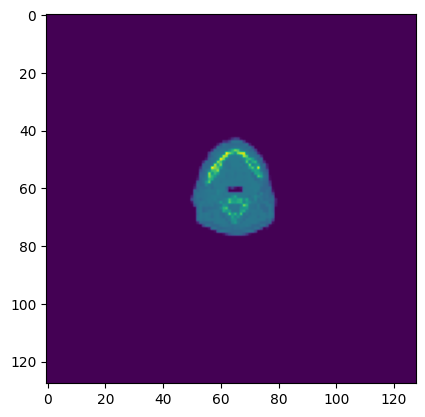

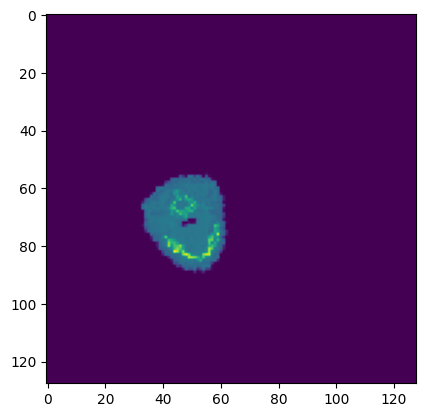

In [11]:
from torchvision.transforms.functional import rotate

s = 64

class Augment(torch.nn.Module):
    def __init__(self, seed):
        super().__init__()
        torch.manual_seed(seed)

    def __call__(self, batch):
        augmented_batch = batch.clone()

        # Rotations
        rotations = [0, 40, 80, 120, 160, 200, 240, 280, 320]
        rot = rotations[torch.randint(0, len(rotations), (1,))]

        augmented_batch = torch.transpose(augmented_batch, 0, 3)
        (_, _, _, batch_size, feature_size) = augmented_batch.shape
    
        for feat in range(feature_size):
            for sample in range(batch_size):
                augmented_batch[:, :, :, sample, feat] = rotate(augmented_batch[:, :, :, sample, feat], rot)
    
        augmented_batch = torch.transpose(augmented_batch, 0, 3)

        # Translations
        shifts = torch.randint(-20, 21, (2,)).int()
        augmented_batch = torch.roll(augmented_batch, shifts=shifts.tolist(), dims=(1, 2))
    
        # Flip
        flips = torch.arange(2, 4)[torch.rand((2,)) > 0.5]
        augmented_batch = torch.flip(augmented_batch, dims=flips.tolist())
        
        return augmented_batch

sample = batch["features"][:, :, :, s, 0]
plt.imshow(torch.squeeze(sample.cpu()))
plt.show()

augment = Augment(1)
rot_sample = augment(batch["features"])[:, :, :, s, 0]
plt.imshow(torch.squeeze(rot_sample.cpu()))
plt.show()